In [62]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

Loading the data

In [63]:
digits = load_digits()
data = digits.data
target = digits.target



Shaping the data

In [64]:
data = data / 16.0  # Rescale to [0, 1]

Encoding data

In [65]:
encoder = OneHotEncoder(sparse_output=False, categories='auto')
target_encoded = encoder.fit_transform(target.reshape(-1, 1))

Function used to visualize one digit

In [66]:
def data_visual(data, target, i):
    plt.figure(figsize=(8, 8))
    plt.imshow(data[i].reshape(8, 8), cmap='gray')
    plt.title(target[i])
    plt.axis('off')
    plt.show() 

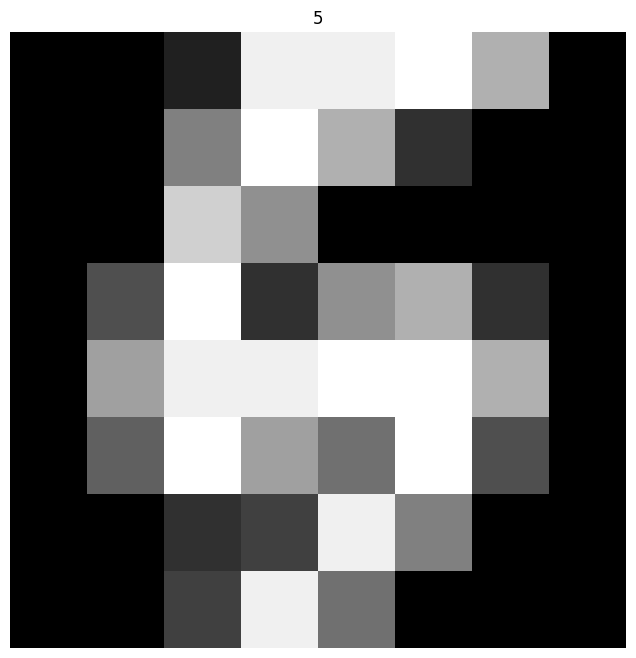

In [67]:
data_visual(data, target, 678)

Function used to creat a mini batch

In [68]:
def data_generator(input_data, target_data, minibatch_size):
    # Get the total number of samples in the dataset
    num_samples = len(input_data)
    
    # Create an array of indices corresponding to the samples
    indices = np.arange(num_samples)
    # Shuffle the indices to randomize the order of samples
    np.random.shuffle(indices)

    # Iterate over the shuffled indices to yield mini-batches
    for start_idx in range(0, num_samples - minibatch_size + 1, minibatch_size):
        # Select a subset of indices for the current mini-batch
        excerpt = indices[start_idx:start_idx + minibatch_size]
        
        # Yield the corresponding input and target data for the mini-batch
        yield input_data[excerpt], target_data[excerpt]

In [69]:
class SigmoidActivation:
    def __call__(self, inputs):
        """
        Apply the sigmoid activation function to the input.
        Args:
        inputs (ndarray): Input data of shape (minibatch_size, num_units).
        Returns:
        ndarray: Output data after applying the sigmoid activation function.
        """
        return 1 / (1 + np.exp(-inputs))
    def backward(self, pre_activation, activation, error_signal):
        """
        Calculate the gradient of the loss with respect to the pre-activation (dL/dpre-activation).
        Args:
        pre_activation (ndarray): Pre-activation values of shape (minibatch_size, num_units).
        activation (ndarray): Activation values (output of the activation function) of the same shape.
        error_signal (ndarray): Gradient of the loss with respect to the activation (dL/dactivation).
        Returns:
        ndarray: Gradient of the loss with respect to the pre-activation (dL/dpre-activation).
        """
        # Calculate the gradient of the sigmoid activation function
        dactivation_dpre_activation = activation * (1 - activation)
        
        # Multiply the gradient of the activation with the error signal to get the gradient of the loss
        dL_dpre_activation = dactivation_dpre_activation * error_signal
        
        return dL_dpre_activation

In [70]:
class SoftmaxActivation:
    def __call__(self, inputs):
        """
        Apply the softmax activation function to the input.
        Args:
        inputs (ndarray): Input data of shape (minibatch_size, 10), where each row represents a vector.
        Returns:
        ndarray: Output data after applying the softmax activation function, with the same shape as inputs.
        """
        # Calculate the exponential of the inputs
        exp_inputs = np.exp(inputs)
        
        # Sum the exponentials along the second axis to compute the denominator
        denominator = np.sum(exp_inputs, axis=1, keepdims=True)
        
        # Compute the softmax probabilities by dividing the exponentials by the denominator
        softmax_output = exp_inputs / denominator
        
        return softmax_output

In [71]:
class MLPLayer:
    def __init__(self, activation, num_units, input_size):
        """
        Initialize the MLP layer.
        Args:
        activation: An instance of an activation function (SigmoidActivation or SoftmaxActivation).
        num_units (int): Number of units (perceptrons) in the layer.
        input_size (int): Number of units in the preceding layer.
        """
        self.activation = activation
        self.num_units = num_units
        self.input_size = input_size
        
        # Initialize weights with small random values (e.g., normal distribution with Î¼=0, Ïƒ=0.2)
        self.weights = np.random.normal(0, 0.2, size=(input_size, num_units))
        
        # Initialize bias values to zero
        self.bias = np.zeros(num_units)
    
    def forward(self, input_data):
        """
        Apply the forward pass of the MLP layer.
        Args:
        input_data (ndarray): Input data of shape (minibatch_size, input_size).
        Returns:
        ndarray: Output data after applying the weight matrix, bias, and activation function.
        """
        # Calculate the pre-activations (z) by applying the weight matrix and adding the bias
        z = np.dot(input_data, self.weights) + self.bias
        
        # Apply the activation function to the pre-activations
        output = self.activation(z)
        
        return output
    def backward_weights(self, dL_dpre_activation, pre_activation, input_data):
        """
        Calculate the gradient of the loss with respect to the weights (dL/dW).
        Args:
        dL_dpre_activation (ndarray): Gradient of the loss with respect to pre-activation.
        pre_activation (ndarray): Pre-activation values.
        input_data (ndarray): Input data of shape (minibatch_size, input_size).
        Returns:
        ndarray: Gradient of the loss with respect to the weights (dL/dW).
        """
        minibatch_size = dL_dpre_activation.shape[0]
        
        # Calculate dL/dW using the outer product of the input and the gradient of the loss
        dL_dW = np.dot(input_data.T, dL_dpre_activation) / minibatch_size
        
        return dL_dW
    def backward_input(self, dL_dpre_activation, pre_activation, weights):
        """
        Calculate the gradient of the loss with respect to the input (dL/dinput).
        Args:
        dL_dpre_activation (ndarray): Gradient of the loss with respect to pre-activation.
        pre_activation (ndarray): Pre-activation values.
        weights (ndarray): Weight matrix.
        Returns:
        ndarray: Gradient of the loss with respect to the input (dL/dinput).
        """
        # Calculate dL/dinput using the dot product of the gradient of the loss and the weight matrix
        dL_dinput = np.dot(dL_dpre_activation, weights.T)
        
        return dL_dinput
    def backward(self, dL_dpre_activation, pre_activation, input_data):
        """
        Calculate the gradients for the entire MLP layer.
        Args:
        dL_dpre_activation (ndarray): Gradient of the loss with respect to pre-activation.
        pre_activation (ndarray): Pre-activation values.
        input_data (ndarray): Input data of shape (minibatch_size, input_size).
        Returns:
        dL_dW (ndarray): Gradient of the loss with respect to the weights (dL/dW).
        dL_dinput (ndarray): Gradient of the loss with respect to the input (dL/dinput).
        """
        dL_dactivation = self.activation.backward(pre_activation, dL_dpre_activation)
        dL_dW = self.backward_weights(dL_dpre_activation, pre_activation, input_data)
        dL_dinput = self.backward_input(dL_dpre_activation, pre_activation, self.weights)
        
        return dL_dW, dL_dinput

In [72]:
class MLP:
    def __init__(self, layer_sizes, activation, input_size):
        # Initialize an empty list to store MLP layers
        self.layers = []

        for i in range(len(layer_sizes)):
            if i == 0:
                # The first layer takes the input size
                self.layers.append(MLPLayer(activation, layer_sizes[i], input_size))
            else:
                # Subsequent layers take the number of units from the previous layer
                self.layers.append(MLPLayer(activation, layer_sizes[i], layer_sizes[i - 1]))

        # Add the final layer with 10 output units and softmax activation
        self.layers.append(MLPLayer(SoftmaxActivation(), 10, layer_sizes[-1]))

    
    def forward(self, input_data):
        """
        Apply the forward pass of the entire MLP.

        Args:
        input_data (ndarray): Input data of shape (minibatch_size, input_size).

        Returns:
        ndarray: Output data after applying the entire MLP.
        """
        # Initialize the input as the input data
        output = input_data
        
        # Iterate through the layers and apply the forward pass
        for layer in self.layers:
            output = layer.forward(output)
        
        return output


    def backward(self, predicted, target):
        """
        Calculate the gradients for the entire MLP and update the weights.

        Args:
        predicted (ndarray): Predicted probabilities or logits (output of the model).
        target (ndarray): True one-hot encoded target labels.

        Returns:
        None
        """
        # Calculate the gradient of the CCE loss with respect to predicted
        dL_dactivation = -target / predicted
        
        # Initialize lists of dictionaries to store activations, pre-activations, and weight gradients
        activations_list = [{} for _ in range(len(self.layers))]
        pre_activations_list = [{} for _ in range(len(self.layers))]
        weight_gradients_list = [{} for _ in range(len(self.layers))]
        
        # Initialize the input_data with the model's output (predicted)
        input_data = predicted  # The first "activation" is the model's output

        # Forward pass to collect activations and pre-activations
        for i, layer in enumerate(self.layers):
            # Calculate the pre-activation
            pre_activation = np.dot(input_data, layer.weights) + layer.bias

            # Store the activation and pre-activation in the respective lists
            activations_list[i]['activation'] = input_data
            pre_activations_list[i]['pre_activation'] = pre_activation

            # Update input_data for the next layer
            input_data = layer.activation(pre_activation)
        
        # Backward pass to compute gradients and update weights
        error_signal = dL_dactivation  # Error signal for the last layer
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            dL_dW, dL_dinput = layer.backward(error_signal, pre_activations_list[i]['pre_activation'], activations_list[i]['activation'])
            weight_gradients_list[i]['dL_dW'] = dL_dW
            error_signal = dL_dinput  # Update error signal for the next layer
        
        # Update the weights of all layers and bias of the last layer
        for i, layer in enumerate(self.layers):
            layer.weights -= weight_gradients_list[i]['dL_dW']
            if i == len(self.layers) - 1:
                # Update bias only for the last layer
                layer.bias -= np.mean(error_signal, axis=0)
        
        return None


In [73]:
class CategoricalCrossEntropyLoss:
    def __call__(self, predicted, target):
        """
        Calculate the categorical cross-entropy loss.
        Args:
        predicted (ndarray): Predicted probabilities or logits (output of the model).
        target (ndarray): True one-hot encoded target labels.
        Returns:
        float: The loss value.
        """
        # Ensure numerical stability by adding a small epsilon to avoid log(0)
        epsilon = 1e-15
        #predicted = np.clip(predicted, epsilon, 1 - epsilon)

        # Calculate the cross-entropy loss

        loss = -np.sum(target * np.log(predicted)) / predicted.shape[0]
        return loss
    
    def backward(self, predicted, loss):
        """
        Calculate the gradient of the loss with respect to the predicted probabilities.

        Args:
        predicted (ndarray): Predicted probabilities or logits (output of the model).
        loss (ndarray): Loss value of shape (minibatch_size, 1).

        Returns:
        ndarray: Gradient of the loss with respect to the predicted probabilities of shape (minibatch_size, 10).
        """
        minibatch_size = predicted.shape[0]
        
        # Initialize an array for the gradients
        gradient = np.zeros_like(predicted)
        
        # Calculate the gradient for each sample in the minibatch
        for i in range(minibatch_size):
            # Compute the derivative of the loss with respect to each element of predicted
            dLCCE_dy = -target[i] / predicted[i]
            
            # Apply the chain rule to get the gradient of the loss with respect to predicted
            dˆy_dz = predicted[i] * (1 - predicted[i])
            
            # Multiply the results to obtain the gradient
            gradient[i] = dLCCE_dy * dˆy_dz
        
        return gradient

In [74]:
def train_mlp(mlp, data, target_encoded, learning_rate, num_epochs, minibatch_size):
    loss_history = []
    accuracy_history = []
    
    for epoch in range(1, num_epochs + 1):
        # Shuffle the data and target_encoded
        indices = np.arange(len(data))
        np.random.shuffle(indices)
        data_shuffled = data[indices]
        target_shuffled = target_encoded[indices]
        
        total_loss = 0
        correct_predictions = 0
        
        for start_idx in range(0, len(data), minibatch_size):
            end_idx = start_idx + minibatch_size
            inputs = data_shuffled[start_idx:end_idx]
            targets = target_shuffled[start_idx:end_idx]
            
            # Forward pass
            predictions = mlp.forward(inputs)

            # Calculate loss
            cce_loss = CategoricalCrossEntropyLoss()
            loss = cce_loss(predictions, targets)
            total_loss += loss
            
            # Calculate accuracy
            correct_predictions += np.sum(np.argmax(predictions, axis=1) == np.argmax(targets, axis=1))
            
            # Backward pass and weight updates
            mlp.backward(predictions, targets)
        
        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(data)
        accuracy = correct_predictions / len(data)
        
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)
        
        print(f"Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy * 100:.2f}%")
    
    # Plot the loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss_history)
    plt.title('Average Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), accuracy_history)
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.show()

Example usage:

In [75]:
num_epochs = 10
learning_rate = 0.01
minibatch_size = 20
mlp = MLP(layer_sizes=[35] , activation=SigmoidActivation(), input_size=64)
cce_loss = CategoricalCrossEntropyLoss()
train_mlp(mlp, data, target_encoded, learning_rate, num_epochs, minibatch_size)

TypeError: CategoricalCrossEntropyLoss() takes no arguments